In [1]:
import numpy as np
import pickle
import os
import cv2
import math
import face_alignment
import matplotlib.pyplot as plt
import scipy.linalg as linalg

In [2]:
from sklearn.neighbors import NearestNeighbors

def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # Step added for scalar (deprecated)
    p_deno = np.sum(AA**2, axis=0)
    y_nume = np.sum(BB**2, axis=0)
    s = np.identity(m+1)
    s[:m, :m] = s[:m, :m] * (y_nume / p_deno) ** 0.25

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    # Step : (Deprecated for Scalar)
    # T = np.dot(s, T)

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=50, tolerance=0.0001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # # find the nearest neighbors between the current source and destination points
        # distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)
        #
        # # compute the transformation between the current source and nearest destination points
        # T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # Step x : just for our T-shape transform, we don'n need this nearest neighbor search
        distances = np.sum((src[:m, :] - dst[:m, :])**2)
        T, _, _ = best_fit_transform(src[:m, :].T, dst[:m, :].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [15]:
def vis_landmark(shape, linewidth=2):
    '''
    Visualize landmark on images.
    '''
    def draw_curve(idx,color,loop=False):
        plt.plot(shape[idx, 0], shape[idx, 1],color=color) # 
#         plt.plot(shape[idx[-1]+1, 0], shape[idx[-1], 1])
        if (loop):
            plt.plot([shape[idx[0], 0],shape[idx[-1], 0]],[shape[idx[0], 1], shape[idx[-1], 1]],color=color)

    draw_curve(list(range(0, 17)),'b')  # jaw
    draw_curve(list(range(17, 22)),'lime')  # eye brow
    draw_curve(list(range(22, 27)),'lime')
    draw_curve(list(range(27, 36)),'c')  # nose
    draw_curve(list(range(36, 42)),'tomato',loop=True)  # eyes
    draw_curve(list(range(42, 48)),'tomato',loop=True)
    draw_curve(list(range(48, 60)),'m',loop=True)  # mouth
    draw_curve(list(range(60, 67)),'m',loop=True)

In [57]:
predictor = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cpu', flip_input=True)
image_path = r'F:\code\avatar\tools\image\75660750-09419780-5c64-11ea-9d2f-97666e6ec82a.jpg'
img = cv2.imread(image_path)
shapes = predictor.get_landmarks(img) 
shapes = shapes[0]
# shapes_n, scale, shift = norm_input_face(shapes.copy())
# pitch, yaw, roll = get_EulerAugles(shapes_n)

In [58]:
t_shape_idx = (27, 28, 29, 30, 33, 36, 39, 42, 45)  # nose position
std_face = np.loadtxt('src/STD_FACE_LANDMARKS.txt')
anchor_t_shape = std_face[t_shape_idx, :]
landmarks = shapes #.detach().cpu().numpy().reshape(68, 3)
frame_t_shape = landmarks[t_shape_idx, :]
T, distance, itr = icp(frame_t_shape, anchor_t_shape)
landmarks = np.hstack((landmarks, np.ones((68, 1))))
registered_landmarks = np.dot(T, landmarks.T).T

In [59]:
registered_landmarks[:,-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## 标准的 landmark

No handles with labels found to put in legend.


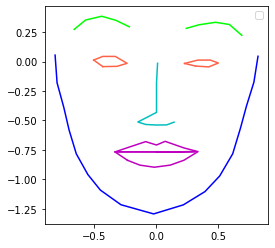

In [60]:
rot_shapes = std_face.copy()
rot_shapes[:,1] = -rot_shapes[:,1]
plt.figure(figsize=(4,4))
vis_landmark(rot_shapes)
plt.legend()
plt.show()

No handles with labels found to put in legend.


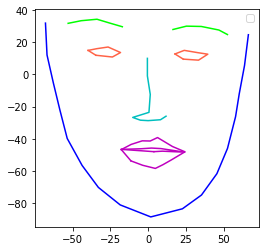

In [61]:
rot_shapes = registered_landmarks.copy()
rot_shapes[:,1] = -rot_shapes[:,1]
plt.figure(figsize=(4,4))
vis_landmark(rot_shapes)
plt.legend()
plt.show()

No handles with labels found to put in legend.


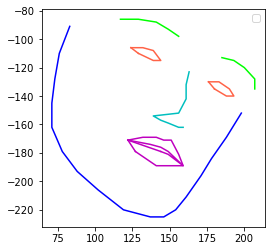

In [62]:
rot_shapes = shapes.copy()
rot_shapes[:,1] = -rot_shapes[:,1]
plt.figure(figsize=(4,4))
vis_landmark(rot_shapes)
plt.legend()
plt.show()

In [20]:
anchor_t_shape.shape

(9, 3)

In [43]:
import pickle

In [44]:
with open(r'F:\dataset\Avatar\Obama\for_MakeItTalk\dump\autovc_retrain_mel_train_gaze.pickle','rb') as f:
    gaze = pickle.load(f)

In [53]:
gaze['anchor_t_shape'][0].shape

(312, 68, 3)